## NHL Season Playoff Outcome Logistic Regression

### Description

The following classification analysis seeks to predict failed playoff outcomes with team season adjusted wins (wins + (ties / 2)) above the mean adjusted wins of any given season for years 1983 - 2020.

The goal of the analysis is to build a model that can use aboveMeanAdjWins to predict playoff outcomes.

By deeply understanding the mentioned features above, a clearer understanding of the path to **not making** and to **making** the playoffs should be gained. 

In [1]:
# Import libraries
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from ipynb.fs.full.Preprocessing_Functions import *
from ipynb.fs.full.AUC_CAP_Functions import *
from pickle import dump 
from pickle import load

### Data Preprocessing

In [2]:
# Import the data frame from the logistic regression EDA
nhl_df = pd.read_csv('Data/NHL_1983_2020_Playoff_Data_Removed_Outliers.csv')
# Drop unneeded columns
nhl_df = nhl_df.drop(['Unnamed: 0'], axis = 1)

# Print Data Summary
nhl_df.info()
nhl_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   aboveMeanAdjWins      887 non-null    float64
 1   predAboveMeanAdjWins  887 non-null    float64
 2   failed_playoff_flag   887 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 20.9 KB


,aboveMeanAdjWins,predAboveMeanAdjWins,failed_playoff_flag
0,-19.470588,-18.536262,1
1,12.029412,12.587617,0
2,6.529412,1.282356,0
3,9.029412,6.603477,0
4,-20.970588,-19.097031,1


The data from the logistic regression EDA analysis is imported.

In [3]:
# Check the frequency of failed_playoff_flag
failed_playoff_flag_strata = nhl_df['failed_playoff_flag'].value_counts() / len(nhl_df)
print(failed_playoff_flag_strata)

0    0.606539
1    0.393461
Name: failed_playoff_flag, dtype: float64


The frequencies of the failed_playoff_flag instances are observed.

In [4]:
# Split the data into an 80/20 train and test stratified split by failed_playoff_flag frequency
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42) 
for train_index, test_index in split.split(nhl_df, nhl_df['failed_playoff_flag']):
    strat_train_set = nhl_df.loc[train_index] 
    strat_test_set = nhl_df.loc[test_index]

The data is at an 80/20 stratified train and test split. This will allow the train and test data to retain the proportion of playoff outcomes (failed_playoff_flag).

Splitting the data through stratified splits will allow for a more robust model.


train and test data season type percent of data:


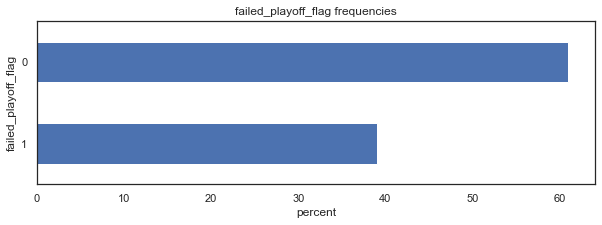

0    61.0
1    39.0
Name: failed_playoff_flag, dtype: float64


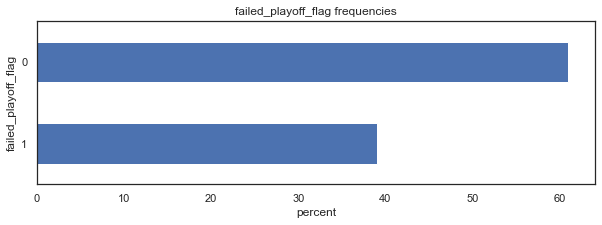

0    61.0
1    39.0
Name: failed_playoff_flag, dtype: float64


In [5]:
# Check the train and test data failed_playoff_flag frequency to test the stratified data split
print('\n' + 'train and test data season type percent of data:')

train_temp = strat_train_set[['failed_playoff_flag']].astype(str)
test_temp = strat_test_set[['failed_playoff_flag']].astype(str)

cat_univariate_freq(df = train_temp, length = 3, width = 10, index_rows = 0, index_col = 1, font = 1)
cat_univariate_freq(df = test_temp, length = 3, width = 10, index_rows = 0, index_col = 1, font = 1)

The stratified train and test split playoff outcome proportions are visualized through the failed_playoff_flag for train and test data.

In [6]:
# Slpit the train set into X_train and y_train
X_train = strat_train_set[strat_train_set.columns[0:len(strat_train_set.columns)-2]].reset_index(drop = True)
y_train = strat_train_set[['failed_playoff_flag']].reset_index(drop = True)

print('\n' + 'train data:' + '\n')
print(X_train.info())
print('\n')
print(y_train.info())

# Slpit the test set into X_test and y_test
X_test = strat_test_set[strat_test_set.columns[0:len(strat_test_set.columns)-2]].reset_index(drop = True)
y_test = strat_test_set[['failed_playoff_flag']].reset_index(drop = True)

print('\n' + 'test data:' + '\n')
print(X_test.info())
print('\n')
print(y_test.info())


train data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   aboveMeanAdjWins  709 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   failed_playoff_flag  709 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB
None

test data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   aboveMeanAdjWins  178 non-null    float64
dtypes: float64(1)
memory usage: 1.5 KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 1 colu

The train and test data are split so X and y values are set to their own data frames.

### Model Training and Testing

#### Model Training, Evaluation, and Interpretation

In [7]:
# Fit and train the logistic regression model
logit_regressor = LogisticRegression()
logit_regressor.fit(X_train, y_train)

# Predict with X_train data
y_pred_train = logit_regressor.predict(X_train)
# Create a data frame from the predicted results
y_pred_train = pd.DataFrame(y_pred_train, columns = ['predictions_train'])

# Creates a data frame from the prediction probabilities
proba = logit_regressor.predict_proba(X_train)
proba = pd.DataFrame(proba, columns = ['0', 'predicted_proba'])
proba = proba[['predicted_proba']]

# Create a separate data frame from y_train
playoff_flag = y_train.reset_index(drop = True).reset_index(drop = True)

# Concatenate all three data frames
results = pd.concat([playoff_flag, y_pred_train, proba], axis = 1)

# Print data summary
print('\n')
results.info()
results.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   failed_playoff_flag  709 non-null    int64  
 1   predictions_train    709 non-null    int64  
 2   predicted_proba      709 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 16.7 KB


,failed_playoff_flag,predictions_train,predicted_proba
0,1,1,0.786444
1,0,0,0.058665
2,0,0,0.025678
3,1,1,0.950548
4,1,0,0.487961


The model is trained to predict failed_playoff_flag output by the aboveMeanAdjWins. 



Pairs:                              ..............119970
Conc:                               ..............114649
Disc:                               ................5299
Tied:                               ..................22


Concordance:                        ................0.96
Discordance:                        ................0.04
Tied:                               .................0.0
Somers D:                           ................0.91




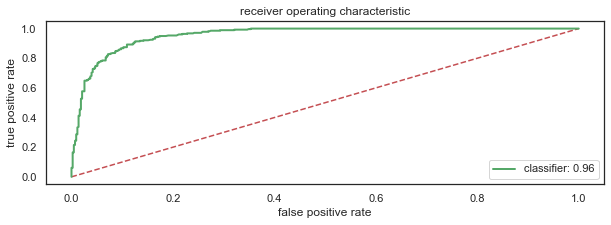



AUC:                                ................0.96


confussion matrix

     1    0
1  393   37
0   43  236


Accuracy:                           ................0.89
Precision:                          ................0.91
Recall:                             .................0.9
F1:                                 .................0.9




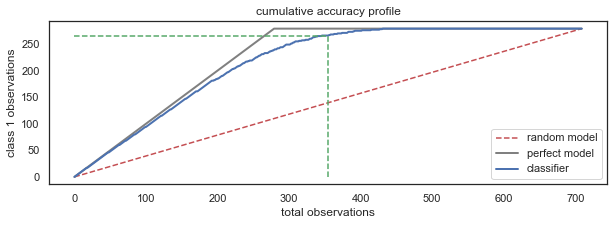

,bin,count_of_rows,failed_playoff_flag,model_percent,random_percent,model_cumm_percent,random_cumm_percent,ks
0,0.0,0,0,0.00,0,0.00,0,0.000000e+00
1,1.0,71,68,24.37,10,24.37,10,1.437000e+01
2,2.0,71,66,23.66,10,48.03,20,2.803000e+01
3,3.0,71,62,22.22,10,70.25,30,4.025000e+01
4,4.0,71,46,16.49,10,86.74,40,4.674000e+01
5,5.0,71,24,8.60,10,95.34,50,4.534000e+01
6,6.0,71,11,3.94,10,99.28,60,3.928000e+01
7,7.0,71,2,0.72,10,100.00,70,3.000000e+01
8,8.0,71,0,0.00,10,100.00,80,2.000000e+01
9,9.0,71,0,0.00,10,100.00,90,1.000000e+01


In [8]:
# Train results
cap_auc(model = logit_regressor, df = results, target = 'failed_playoff_flag', y = playoff_flag, 
        y_pred = y_pred_train, y_score = proba, X = X_train, length = 3, width = 10)

The train model shows strong results. 

Notable observations:

1) **Concordance - 0.96** - This shows that the model probability thresholds are functioning efficiently. To rephrase, for every pair of positives and negative predictions, 94% of the time, positive predictions have higher probabilities than negative predictions.<br><br>

2) **Area Under the Curve (AUC) 0.96** - Being similar to **concordance**, AUC is concordance + (tied output pairs * 0.5) and because the model contains no tied pairs when calculating concordance, the AUC is the same as concordance itself. To rephrase, there is a 96% chance that the model will be able to distinguish between 1 and 0.<br><br>

3) **F1 - 0.90** - This shows that the model is working to make predictions based on the variance of predictors. To rephrase, the model is not making predictions full of positives and false positives or negatives and false negatives to attain high accuracy. F1 (harmonic mean of precision and recall) describes that out of all positives predicted 0.90 are correct (precision) and out of all positive outcomes in the data, 0.90 were predicted by the model correct (recall).<br><br>

4) **Kolmogorov-Smirnov Measure (ks)** - shows that the model predicts 87% of the data's true positives in the first 4 deciles of the data. The difference between the model and what a random model predicts is ks (87% - 40% = 47%). To rephrase, this means that the model improves prediction from the random base by 2.2 times peaking at the 4th decile of the data displaying the model's efficiency to filter for true positive predictions.<br><br>

In [9]:
# Logistic summary for X_train
logit_summary(X = X_train, y = playoff_flag)

Optimization terminated successfully.
         Current function value: 0.272267
         Iterations 8
                           Results: Logit
Model:              Logit               Pseudo R-squared: 0.594      
Dependent Variable: failed_playoff_flag AIC:              390.0740   
Date:               2021-05-09 02:52    BIC:              399.2017   
No. Observations:   709                 Log-Likelihood:   -193.04    
Df Model:           1                   LL-Null:          -475.24    
Df Residuals:       707                 LLR p-value:      9.2707e-125
Converged:          1.0000              Scale:            1.0000     
No. Iterations:     8.0000                                           
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
const                -1.0092   0.1423  -7.0896 0.0000 -1.2881 -0.7302
aboveMeanAdjWins

Comparing AIC with -2 Log-Likelihood is virtually similar because the model contains only one feature plus the y-intercept.

The train model coefficient, significant at p < 0.05, shows that for every one-unit increase in aboveMeanAdjWins, the log odds of not making the playoffs decrease by -0.52.

The more teams increase their adjusted wins above the mean adjusted wins for any given season, the probability of them not making the playoffs decreases.

#### Model Testing, Evaluation, and Interpretation

In [10]:
# Predict with X_test data
y_pred_test = logit_regressor.predict(X_test)
# Create a data frame from the predicted results
y_pred_test = pd.DataFrame(y_pred_test, columns = ['predictions_train'])

# Creates a data frame from the prediction probabilities
proba = logit_regressor.predict_proba(X_test)
proba = pd.DataFrame(proba, columns = ['0', 'predicted_proba'])
proba = proba[['predicted_proba']]

# Create a separate data frame from y_test
playoff_flag = y_test.reset_index(drop = True).reset_index(drop = True)

# Concatenate all three data frames
results = pd.concat([playoff_flag, y_pred_test, proba], axis = 1)

# Print data summary
print('\n')
results.info()
results.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   failed_playoff_flag  178 non-null    int64  
 1   predictions_train    178 non-null    int64  
 2   predicted_proba      178 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 4.3 KB


,failed_playoff_flag,predictions_train,predicted_proba
0,0,0,0.496349
1,0,0,0.073310
2,0,0,0.319240
3,0,0,0.001635
4,0,0,0.058189


Using the test data, the model is used to predict the failed_playoff_flag output by aboveMeanAdjWins.



Pairs:                              ................7560
Conc:                               ................7032
Disc:                               .................527
Tied:                               ...................1


Concordance:                        ................0.93
Discordance:                        ................0.07
Tied:                               .................0.0
Somers D:                           ................0.86




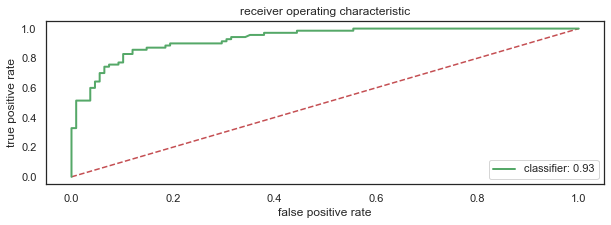



AUC:                                ................0.93


confussion matrix

     1   0
1  101   7
0   18  52


Accuracy:                           ................0.86
Precision:                          ................0.94
Recall:                             ................0.85
F1:                                 ................0.89




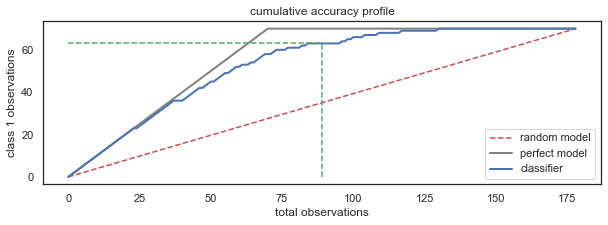

,bin,count_of_rows,failed_playoff_flag,model_percent,random_percent,model_cumm_percent,random_cumm_percent,ks
0,0.0,0,0,0.00,0,0.00,0,0.00
1,1.0,18,18,25.71,10,25.71,10,15.71
2,2.0,18,17,24.29,10,50.00,20,30.00
3,3.0,18,13,18.57,10,68.57,30,38.57
4,4.0,18,11,15.71,10,84.28,40,44.28
5,5.0,18,4,5.71,10,89.99,50,39.99
6,6.0,18,4,5.71,10,95.70,60,35.70
7,7.0,18,2,2.86,10,98.56,70,28.56
8,8.0,18,1,1.43,10,99.99,80,19.99
9,9.0,18,0,0.00,10,99.99,90,9.99


In [11]:
# Test results
cap_auc(model = logit_regressor, df = results, target = 'failed_playoff_flag', y = playoff_flag, 
        y_pred = y_pred_test, y_score = proba, X = X_test, length = 3, width = 10)

The model shows strong results on the test data. The results are slightly lower, however, this is to be expected on the test data.

Notable observations:

1) **Concordance** - 0.93 <br>

2) **Area Under the Curve (AUC)** - 0.93<br>

3) **F1** - 0.89<br>

4) **Kolmogorov-Smirnov Measure (ks)** - 44% at the 4th decile, a cumulative percentage 2.1 (84% (model) / 40% (random model)) times greater than a random model.<br>

### Model Finalization

In [12]:
# Set X values
X = nhl_df[['aboveMeanAdjWins']]
# Set y values
y = nhl_df[['failed_playoff_flag']]

# Print data results
print('\n')
print(X.info())
print('\n')
print(y.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   aboveMeanAdjWins  887 non-null    float64
dtypes: float64(1)
memory usage: 7.1 KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   failed_playoff_flag  887 non-null    int64
dtypes: int64(1)
memory usage: 7.1 KB
None


Create an X and y data frame for the entire data set.

In [13]:
# Fit and train the logistic regression model
logit_regressor = LogisticRegression()
logit_regressor.fit(X, y)

LogisticRegression()

Train model on entire data set to finalize the model.

In [14]:
# save the model
dump(logit_regressor, open('NHL_Playoffs_Logistic_Regression_Model.pkl', 'wb'))

Save logistic regression model.

In [15]:
# load the model
model = load(open('NHL_Playoffs_Logistic_Regression_Model.pkl', 'rb'))

Load logistic regression model.

### Summary

aboveMeanAdjWins has proven to be an effective feature when predicting playoff contention for NHL organizations.

If teams want to make the playoffs they need to increase their aboveMeanAdjWins. To increase their aboveMeanAdjWins, teams must seek to focus on:

1) **shootingPctg**
* Feature importance: 6.1121
* Coef: 3.9575<br>

2) **savePctg**
* Feature importance: 6.0182
* Coef: 4.1279<br>

3) **savesPerGame**
* Feature importance: -3.2024
* Coef: -1.3473<br>

4) **failedShotsPerGame**
* Feature importance: 2.7283
* Coef: 1.3688<br>

5) **winScoreFirstGreater61_high**
* Feature importance: 0.6539
* Coef: 1.3581<br>

Features are in descending order basis importance.<br>
Features that are positive values, teams should look to increase them.<br>
Features with negative values, teams should look to decrease them.